# A Practical Guide to Model Quantization in PyTorch

Deploying deep learning models often requires optimizing them for efficiency, especially in environments with limited resources. While models are typically trained using high-precision 32-bit floating-point numbers to capture the small, exact adjustments needed during learning, this level of precision is not always necessary for inference once the model is trained. 

**Model quantization** addresses this by converting a model's weights and activations to a lower-precision format, like 8-bit integers, leading to smaller model sizes and faster performance.

In this notebook, you will embark on a hands-on journey through the landscape of quantization with PyTorch. You will begin by establishing a performance benchmark with a standard floating-point model. Then, you will explore and apply three distinct strategies, each building on the last, to see their effects in practice.

* **Dynamic Quantization**: You'll start with a straightforward, post-training technique that provides an immediate size reduction with minimal code by converting weights to integers and quantizing activations on-the-fly during inference.
* **Static Quantization**: Next, you'll implement a more involved post-training method that can yield better performance. This technique involves a **calibration** step, where you run sample data through the model to determine the best way to quantize the activations ahead of time.
* **Quantization-Aware Training (QAT)**: Finally, you'll use the most advanced technique, which simulates quantization effects during a fine-tuning phase. This allows the model to adapt its weights to the rounding noise, helping to achieve the highest possible accuracy in the final quantized model.

To see these concepts applied in a practical scenario, an optional section will guide you through quantizing a large, pre-trained Visual Question Answering (VQA) model. Through this process, you will gain the practical knowledge to evaluate trade-offs and choose the right optimization strategy for your own projects.

In [1]:
from IPython.display import Image as DisplayImage
import torch
import torch.nn as nn
import torch.quantization
from tqdm.auto import tqdm

import helper_utils

In [2]:
# Set the device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using DEVICE: {DEVICE}")

Using DEVICE: cuda


## Baseline Model

Before applying advanced optimization techniques like quantization, it is crucial to first establish a benchmark. This benchmark is your baseline model — the original, fully-trained, and un-optimized version of the network.

By measuring its key performance characteristics, such as model size and inference speed, you create a standard reference point. This baseline is essential because it allows you to concretely measure the effectiveness of your optimizations. Later, as you apply different quantization techniques, you will compare the results of each new model directly against this baseline to clearly see the improvements and any potential trade-offs. 

### CNN Model Architecture

* Define the architecture for the Convolutional Neural Network (`CNN`) that will be used as a baseline throughout this lab.
* The architecture includes:
    * A sequence of `torch.nn.Conv2d` layers for feature extraction, each followed by a `torch.nn.BatchNorm2d` layer to stabilize learning.
    * `torch.nn.MaxPool2d` layers to downsample the feature maps after each convolutional block.
    * `torch.nn.Dropout` applied between the fully connected layers to reduce overfitting.
    * A final classification head made of three `torch.nn.Linear` layers.
    * The `forward` method orchestrates the flow of data through these layers.

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define the convolutional and batch normalization layers 
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        # Define a max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Define a dropout layer
        self.dropout = nn.Dropout(0.2)
        # Define the fully connected layers for the classification head 
        self.fc1 = nn.Linear(512 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        # Define the ReLU activation function
        self.relu = nn.ReLU()

    # Define the forward pass of the model
    def forward(self, x):
        # Pass input through the sequence of convolutional blocks 
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))

        # Flatten the output from the convolutional layers for the fully connected layers 
        x = x.view(-1, 512 * 2 * 2) 
        # Pass data through the fully connected layers 
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x) 
        
        return x

### Loading the Dataset

* Call the helper function, `load_cifar10`, to download and prepare the `CIFAR10` dataset.
* It creates and returns `trainloader` and `testloader`.

In [4]:
trainloader, testloader = helper_utils.load_cifar10()

CIFAR10 Data folder found locally. Loading from local.



### Model Training (Optional)

The next logical step is to train the `CNN` model on the CIFAR10 dataset. However, training can be time-consuming, taking approximately 10 minutes for 30 epochs in this GPU environment.

To save time, you are provided a pre-trained model that has already been trained. Below are the logs from its training session. 

<center>
    <img src="pretrained_model_logs.png" alt="Model Train Logs" width="1000">
</center>

The best results achieved were: a validation loss of **0.4086** and an accuracy of **88.20%**.

* **Validation Loss:** 0.4086
* **Validation Accuracy:** 88.20%

```python
# Initialize the model
model = CNN()

# Set number of training epochs
num_epochs = 30

# Run the training loop
helper_utils.training_loop(model, trainloader, testloader, num_epochs, DEVICE)
```

### Load the Pre-trained Model

* Define the path to the provided pretrained model, `cifar10_cnn_30_epochs_best.pt`.
    * **NOTE**: If you trained your own model in the optional cell above, please make sure to set the path to `baseline_model_path = 'cifar10_cnn_best.pt'`, which is the name used by the training script for the saved model.

In [5]:
baseline_model_path = 'cifar10_cnn_30_epochs_best.pt'

* Create an instance of the `CNN` model.
* Load the pre-trained weights from the `baseline_model_path` into the model structure.
* Switch the model to evaluation mode, which is a necessary step for the quantization APIs to work correctly. 

In [6]:
# Create an instance of the CNN model architecture
baseline_model = CNN()
# Load the pre-trained weights from the file specified in baseline_model_path
baseline_model.load_state_dict(torch.load(baseline_model_path))
# Set the model to evaluation mode
baseline_model.eval()

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (relu)

### Baseline Performance Metrics

* Calculate the model's size and inference time to establish the baseline performance metrics for the quantization comparisons.

In [7]:
# Calculate the model's size in megabytes (MB)
baseline_model_size = helper_utils.get_model_size(baseline_model)
# Measure the average inference time in milliseconds (ms)
baseline_model_inf_time = helper_utils.measure_average_inference_time_ms(baseline_model)

# Print the metrics
print(f"Baseline model size: {baseline_model_size:.2f} MB")
print(f"Baseline model inference time: {baseline_model_inf_time:.2f} ms")

Baseline model size: 15.97 MB
Baseline model inference time: 2.16 ms


## Dynamic Quantization

With the baseline established, you can now begin optimizing the model. The first and simplest approach you will explore is **Dynamic Quantization**. 

This strategy is straightforward: it involves converting only the weights in the model from the standard 32-bit floating-point format to a more efficient, lower-precision format like 8-bit integers (INT8).  The activations, on the other hand, are calculated in floating-point during inference and are quantized on-the-fly as they are passed to the quantized weight operations.  This method is easy to apply and can yield significant benefits, such as reducing the model's size by half and speeding up inference time. 

Before you apply this technique, it's useful to inspect the current data types of the model's weights. The following code will print the dtype for each Conv2d and Linear layer, giving you a clear "before" picture that confirms all weights are in the standard torch.float32 format.

* Print the `dtype` for each `Conv2d` and `Linear` layer, giving you a clear "before" picture that confirms all weights are in the standard `torch.float32` format.

In [8]:
print("--- Weight dtypes before quantization ---")
# Iterate through the model's layers
for name, module in baseline_model.named_modules():
    # Check if the layer is a Conv2d or Linear layer
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        print(f"Layer: {name:<10} | Weight dtype: {module.weight.dtype}")

--- Weight dtypes before quantization ---
Layer: conv1      | Weight dtype: torch.float32
Layer: conv2      | Weight dtype: torch.float32
Layer: conv3      | Weight dtype: torch.float32
Layer: conv4      | Weight dtype: torch.float32
Layer: fc1        | Weight dtype: torch.float32
Layer: fc2        | Weight dtype: torch.float32
Layer: fc3        | Weight dtype: torch.float32


### Applying Dynamic Quantization

* Use the [torch.quantization.quantize_dynamic](https://docs.pytorch.org/docs/stable/generated/torch.ao.quantization.quantize_dynamic.html) function to perform this operation.
    * `baseline_model`: The first argument is the floating-point model you want to quantize.
    * `{nn.Linear, nn.Conv2d}`: This specifies the set of layer types you want to dynamically quantize.
    * `dtype=torch.qint8`: This tells the function the target data type for the quantized weights.
* Save the state dictionary of the newly created quantized model.

In [9]:
# Apply dynamic quantization
quantized_dynamic_model = torch.quantization.quantize_dynamic(
    # Model to be quantized. 
    baseline_model,
    # The layers to quantize
    {nn.Linear, nn.Conv2d},
    # The target data type for the quantized weights
    dtype=torch.qint8
)

# Save the state dictionary of the newly quantized model. 
torch.save(quantized_dynamic_model.state_dict(), 'cifar10_cnn_quantized_dynamic.pth')

*After* quantization, the specified layers are swapped out for new, dynamically quantized versions. This means:

* Your previous `torch.nn.Linear` layers are now instances of `torch.nn.quantized.dynamic.Linear`.
* Similarly, any `torch.nn.Conv2d` layers would become `torch.nn.quantized.dynamic.Conv2d`.

You can now inspect the data types of these new layers to confirm the change.

In [10]:
print("--- Weight dtypes after dynamic quantization ---")
# Iterate through the quantized model's layers
for name, module in quantized_dynamic_model.named_modules():
    # Check if the layer is a dynamically quantized Conv2d or Linear layer
    if isinstance(module, (torch.nn.quantized.dynamic.Conv2d, torch.nn.quantized.dynamic.Linear)):
        # For quantized layers, the weight is packed and must be accessed as a method
        print(f"Layer: {name:<10} | Weight dtype: {module.weight().dtype}")

--- Weight dtypes after dynamic quantization ---
Layer: fc1        | Weight dtype: torch.qint8
Layer: fc2        | Weight dtype: torch.qint8
Layer: fc3        | Weight dtype: torch.qint8


<br>

Notice something interesting? Even though you passed `nn.Conv2d` layers to the function, only the `Linear` layers were actually converted to the `torch.qint8` data type. This is because PyTorch's dynamic quantization implementation is highly optimized for operations where the weights are the primary bottleneck, which is most often the case with `Linear` layers.

This isn't a limitation of quantization overall. The more advanced techniques you'll explore next, **Static Quantization** and **Quantization-Aware Training (QAT)**, are designed to handle and quantize `Conv2d` layers effectively, which is essential for getting the best performance out of CNN architectures.

### Compare Performance

* Now that you've applied dynamic quantization, measure the size and inference speed of the new model compared with the baseline model.

In [11]:
# Calculate the model's size in megabytes (MB)
quantized_dynamic_model_size = helper_utils.get_model_size(quantized_dynamic_model)
# Measure the average inference time in milliseconds (ms)
quantized_dynamic_model_inf_time = helper_utils.measure_average_inference_time_ms(quantized_dynamic_model)

# Generate the Markdown comparison table
helper_utils.comparison_table(
    baseline_model_size=baseline_model_size,
    baseline_model_time=baseline_model_inf_time,
    quantized_model_size=quantized_dynamic_model_size,
    quantized_model_time=quantized_dynamic_model_inf_time,
    quantization_type="Dynamic"
)


| | Baseline Model | Quantized Model (Dynamic) | Change |
|:---|:---|:---|:---|
| **Model Size (MB)** | 15.97 | 8.45 | 7.51 |
| **Inference Latency (ms)** | 2.16 | 2.11 | 0.05 |


## Static Quantization

Next, you will explore **Static Quantization**, a more powerful but also more involved optimization technique compared to its dynamic counterpart.

The key difference is that static quantization converts both the model's weights and its activations to a lower-precision integer format, such as INT8. Because activations are also being quantized, the process requires an extra, critical step: **calibration**.

The following cells will guide you through the complete workflow:

### Statically Quantized CNN Architecture

* Define a new `QuantizedCNN` class with two key additions:
    * <code>self.quant = [torch.quantization.QuantStub()](https://docs.pytorch.org/docs/2.7/generated/torch.ao.quantization.QuantStub.html#torch.ao.quantization.QuantStub)</code>: This is a "quantization stub" module that you will place at the very beginning of your `forward` pass. Its job is to convert the incoming floating-point tensors into quantized tensors.
    * <code>self.dequant = [torch.quantization.DeQuantStub()](https://docs.pytorch.org/docs/2.7/generated/torch.ao.quantization.DeQuantStub.html#torch.ao.quantization.DeQuantStub)</code>: This is a "dequantization stub" that you will place at the very end. It converts the quantized output tensors back into floating-point format.
* The rest of the architecture remains identical to the original CNN.

In [12]:
class QuantizedCNN(nn.Module):
    def __init__(self):
        super(QuantizedCNN, self).__init__()
        # Add a QuantStub module. This will convert the incoming floating-point tensor to a quantized tensor. 
        self.quant = torch.quantization.QuantStub()

        # The core layers of the model remain the same as the baseline CNN. 
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.fc1 = nn.Linear(512 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

        # Add a DeQuantStub module. This will convert the final quantized tensor back to a floating-point tensor. 
        self.dequant = torch.quantization.DeQuantStub()

    def forward(self, x):
        # Explicitly quantize the input tensor at the beginning of the forward pass. 
        x = self.quant(x)

        # The main forward pass logic remains the same.
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))

        x = x.reshape(-1, 512 * 2 * 2)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)

        # Explicitly dequantize the output tensor before returning it. 
        x = self.dequant(x)
        
        return x

### Prepare Model for Static Quantization

* Perform the initial setup required before you can calibrate and convert the model.
    * First, create an instance of your new `QuantizedCNN` class.
    * Next, copy the weights from the original trained `baseline_model` into this new quantization-ready instance.
    * Set the model to evaluation mode.
    * Finally, you attach a quantization configuration (`qconfig`) to the model. Here, you use `torch.quantization.get_default_qconfig('x86')`, which is the recommended default configuration for server-side inference on x86 CPUs. This step also implicitly prepares the model by inserting "observer" modules that will be used to analyze data flow in the next step.
        * **NOTE:** While the older `'fbgemm'` backend is still available, `'x86'` is the new recommended default.

In [13]:
# Create an instance of the new QuantizedCNN class
quantized_static_model = QuantizedCNN()

# Copy the learned weights from the pre-trained baseline_model into the new quantized_static_model
quantized_static_model.load_state_dict(baseline_model.state_dict())
# Set the model to evaluation mode
quantized_static_model.eval()

# Set the quantization configuration for the model. 
# 'fbgemm' is a configuration optimized for server-side inference on x86 CPUs. 
# This also attaches observer modules that will be used during calibration. 
quantized_static_model.qconfig = torch.quantization.get_default_qconfig('x86')

### Prepare and Calibrate

* Use [torch.quantization.prepare](https://docs.pytorch.org/docs/stable/generated/torch.ao.quantization.prepare.html).
    * This function takes the model with the attached `qconfig` and formally prepares it for calibration by activating the observer modules that were inserted in the previous step. These observers are now ready to watch the data that flows through the model.

In [14]:
# Prepare model for quantization
torch.quantization.prepare(quantized_static_model, inplace=True)

QuantizedCNN(
  (quant): QuantStub(
    (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
  )
  (conv1): Conv2d(
    3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
    (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
  )
  (bn1): BatchNorm2d(
    64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
  )
  (conv2): Conv2d(
    64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
    (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
  )
  (bn2): BatchNorm2d(
    128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
  )
  (conv3): Conv2d(
    128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
    (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
  )
  (bn3): BatchNorm2d(
    256, eps=1e-05, momentum=0

<br>

After preparing the model, you can inspect its layers. At this stage, no weights have been converted yet. The preparation step has inserted **observer modules** that will watch the data flow during calibration, but the core layers still use 32-bit floating-point weights.

* Print the `dtype` for each `Conv2d` and `Linear` layer to confirm they are still in `torch.float32` format before calibration and conversion.

In [15]:
print("--- Weight dtypes before static conversion ---")
# Iterate through the model's layers
for name, module in quantized_static_model.named_modules():
    # Check if the layer is a Conv2d or Linear layer
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        print(f"Layer: {name:<10} | Weight dtype: {module.weight.dtype}")

--- Weight dtypes before static conversion ---
Layer: conv1      | Weight dtype: torch.float32
Layer: conv2      | Weight dtype: torch.float32
Layer: conv3      | Weight dtype: torch.float32
Layer: conv4      | Weight dtype: torch.float32
Layer: fc1        | Weight dtype: torch.float32
Layer: fc2        | Weight dtype: torch.float32
Layer: fc3        | Weight dtype: torch.float32


<br>

**Calibration** is a step unique to static quantization where you must feed the model representative, unlabelled data. This allows the observers to watch the range and distribution of the activation tensors at different points in the model.

* Define a `calibrate` function to perform this process.
* The function takes in the prepared `quantized_static_model` and the `testloader`. It will iterate through a number of batches, and for each batch, it will run a forward pass.
    * During these passes, the observers collect statistics that will be used to determine the optimal quantization parameters for the activations.

In [16]:
def calibrate(model, data_loader, num_batches=50):
    """Feeds sample data through the model to calibrate quantization observers."""
    
    # Set the model to evaluation mode
    model.eval()
    
    # Determine the actual number of batches for calibration
    # It's the smaller of num_batches or the total size of the data_loader
    total_batches_available = len(data_loader)
    calibration_batches = min(num_batches, total_batches_available)

    # Use torch.no_grad()
    with torch.no_grad():
        # Wrap the data_loader with tqdm for a progress bar
        progress_bar = tqdm(data_loader, total=calibration_batches, desc="Calibrating")
        
        # Iterate through the specified number of batches
        for i, (image, _) in enumerate(progress_bar):
            # Break the loop if processed enough batches
            if i >= calibration_batches:
                break
            
            # Feed the data to the model. This activates the observers.
            model(image)

    print(f"\nCalibration finished after processing {calibration_batches} out of {total_batches_available} batches.")

In [17]:
# Calibrate with sample data
calibrate(quantized_static_model, testloader)

Calibrating:   0%|          | 0/50 [00:00<?, ?it/s]


Calibration finished after processing 50 out of 79 batches.


### Convert and Save Model

* Now that the model has been calibrated, [convert](https://docs.pytorch.org/docs/stable/generated/torch.ao.quantization.convert.html) it into a fully quantized model.
    * This takes the calibrated model and uses the statistics gathered by the observers to permanently convert the model's weights and activations to the INT8 format.
    * The `inplace=True` argument modifies the model directly, which saves memory by not creating a new copy.

In [18]:
# Convert the prepared and calibrated model to a fully quantized model
torch.quantization.convert(quantized_static_model, inplace=True)

QuantizedCNN(
  (quant): Quantize(scale=tensor([0.0323]), zero_point=tensor([62]), dtype=torch.quint8)
  (conv1): QuantizedConv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.050477754324674606, zero_point=61, padding=(1, 1))
  (bn1): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): QuantizedConv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), scale=0.28366053104400635, zero_point=80, padding=(1, 1))
  (bn2): QuantizedBatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): QuantizedConv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), scale=0.25080516934394836, zero_point=78, padding=(1, 1))
  (bn3): QuantizedBatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): QuantizedConv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), scale=0.3429197072982788, zero_point=68, padding=(1, 1))
  (bn4): QuantizedBatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_runnin

<br>

Now that the model has been converted, you can inspect the data types again. 

*After* static quantization, the `Conv2d` and `Linear` layers are replaced with their fused and quantized counterparts. This means:

* Your previous `torch.nn.Conv2d` layers are now instances of `torch.nn.quantized.Conv2d`.
* Your previous `torch.nn.Linear` layers are now instances of `torch.nn.quantized.Linear`.

Run the following cell to confirms that, unlike dynamic quantization, **both the convolutional and linear layers** have been successfully converted to use `torch.qint8` weights.

In [19]:
print("--- Weight dtypes after static conversion ---")
# Iterate through the quantized model's layers
for name, module in quantized_static_model.named_modules():
    # Check if the layer is a statically quantized Conv2d or Linear layer
    if isinstance(module, (torch.nn.quantized.Conv2d, torch.nn.quantized.Linear)):
        print(f"Layer: {name:<10} | Weight dtype: {module.weight().dtype}")

--- Weight dtypes after static conversion ---
Layer: conv1      | Weight dtype: torch.qint8
Layer: conv2      | Weight dtype: torch.qint8
Layer: conv3      | Weight dtype: torch.qint8
Layer: conv4      | Weight dtype: torch.qint8
Layer: fc1        | Weight dtype: torch.qint8
Layer: fc2        | Weight dtype: torch.qint8
Layer: fc3        | Weight dtype: torch.qint8


<br>

* Save the state dictionary of the final, highly optimized model.

In [20]:
# Save the state dictionary of the final, statically quantized model to a file
torch.save(quantized_static_model.state_dict(), 'cifar10_cnn_quantized_static.pth')

### Compare Performance

* Now that you've applied static quantization, measure the size and inference speed of the new model compared with the baseline model.

In [21]:
# Calculate the model's size in megabytes (MB)
quant_static_model_size = helper_utils.get_model_size(quantized_static_model)
# Measure the average inference time in milliseconds (ms)
quant_static_model_inf_time = helper_utils.measure_average_inference_time_ms(quantized_static_model)

# Generate the Markdown comparison table
helper_utils.comparison_table(
    baseline_model_size=baseline_model_size,
    baseline_model_time=baseline_model_inf_time,
    quantized_model_size=quant_static_model_size,
    quantized_model_time=quant_static_model_inf_time,
    quantization_type="Static"
)


| | Baseline Model | Quantized Model (Static) | Change |
|:---|:---|:---|:---|
| **Model Size (MB)** | 15.97 | 4.07 | 11.90 |
| **Inference Latency (ms)** | 2.16 | 1.10 | 1.06 |


## Quantization-Aware Training (QAT)

Finally, you will explore **Quantization-Aware Training (QAT)**. This is the most involved quantization method, but it can yield the best performance and accuracy compared to post-training methods.

Unlike the previous techniques, QAT simulates the effects of quantization *during* a training or fine-tuning phase. This allows the model to adapt its weights to the precision loss introduced by quantization, which can significantly improve the final accuracy of the quantized model.

The workflow involves several key stages which you will now step through.

### QAT-Ready CNN 

To perform QAT and the necessary optimization of "layer fusion," you must first modify the baseline CNN architecture.

* **Separate ReLU Modules**: Activation functions like `ReLU` are defined as separate layers (e.g., `self.relu1`) instead of being called functionally within the `forward` pass. This is a requirement for layer fusion.
* **Layer Fusion Method**: A `fuse_model` method is added to perform layer fusion. It uses the [torch.quantization.fuse_modules](https://docs.pytorch.org/docs/stable/generated/torch.ao.quantization.fuse_modules.fuse_modules.html) function to combine common sequences like (Conv, BN, ReLU) into single, optimized layers.
* **Quantization Stubs**: Just like with static quantization, `QuantStub` and `DeQuantStub` are added to mark the entry and exit points for quantization.
* **QAT-Compatible Operations**: Some operations are not supported in the QAT workflow. For example, `.view()` has been replaced with `.reshape()`, which is supported.

In [22]:
class QATCNN(nn.Module):
    def __init__(self):
        super(QATCNN, self).__init__()
        # Add a QuantStub module to convert the input from float to quantized format.
        self.quant = torch.quantization.QuantStub()
        # Add a DeQuantStub module to convert the output from quantized to float format.
        self.dequant = torch.quantization.DeQuantStub()

        # --- Define the model's layers ---
        # Note: For QAT and layer fusion, ReLU activations must be defined as separate nn.Module layers.
        
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)

        # Convolutional Block 2
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)

        # Convolutional Block 3
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU(inplace=True)

        # Convolutional Block 4
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.relu4 = nn.ReLU(inplace=True)

        # Shared layers
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        
        # Fully Connected Block 1
        self.fc1 = nn.Linear(512 * 2 * 2, 1024)
        self.relu_fc1 = nn.ReLU(inplace=True)

        # Fully Connected Block 2
        self.fc2 = nn.Linear(1024, 512)
        self.relu_fc2 = nn.ReLU(inplace=True)

        # Output Layer
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        # 1. Quantize the input tensor.
        x = self.quant(x)

        # 2. Pass data through the network, using the separated layer modules.
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.relu4(self.bn4(self.conv4(x)))
        x = self.pool(x)

        # Reshape for the fully connected layers.
        x = x.reshape(-1, 512 * 2 * 2)
        
        x = self.relu_fc1(self.fc1(x))
        x = self.dropout(x)
        x = self.relu_fc2(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        # 3. Dequantize the output tensor before returning.
        x = self.dequant(x)
        return x

    def fuse_model(self):
        # Define a new method to fuse layers. This is a key optimization for QAT.
        # It combines a sequence of layers (e.g., Conv, BN, ReLU) into a single, more efficient layer.
        
        # Fuse convolutional blocks
        torch.quantization.fuse_modules(self, ['conv1', 'bn1', 'relu1'], inplace=True)
        torch.quantization.fuse_modules(self, ['conv2', 'bn2', 'relu2'], inplace=True)
        torch.quantization.fuse_modules(self, ['conv3', 'bn3', 'relu3'], inplace=True)
        torch.quantization.fuse_modules(self, ['conv4', 'bn4', 'relu4'], inplace=True)
        
        # Fuse fully connected blocks
        torch.quantization.fuse_modules(self, ['fc1', 'relu_fc1'], inplace=True)
        torch.quantization.fuse_modules(self, ['fc2', 'relu_fc2'], inplace=True)

### Prepare Model for QAT

Since the `QATCNN` architecture is different from the original `CNN`, you cannot simply load the weights. You must first create a mapping to transfer the learned weights from the baseline model to the new QAT-ready architecture.

#### Instantiate Model and Load Weights

* First, create an instance of the new `QATCNN` model.
* Next, load the `state_dict` (which contains the learned weights) from the pre-trained `baseline_model` into memory.

In [23]:
# Create an instance of the QAT-ready model architecture
qat_model = QATCNN()

# Load the state dictionary from the pre-trained baseline model using the defined path
baseline_model_state_dict = torch.load(baseline_model_path)

# Get the state dictionary of the new, un-trained QAT model.
qat_model_state_dict = qat_model.state_dict()

#### Map and Transfer Weights

* Now, define a `mapping` dictionary to explicitly link the layer names from the old model architecture to the new one.
* Finally, iterate through this mapping to transfer the weights and load the updated `state_dict` into your `qat_model`.

In [24]:
# Define the mapping to transfer weights
mapping = {
    # conv1
    "conv1.weight": "conv1.weight",
    "conv1.bias": "conv1.bias",
    "bn1.weight": "bn1.weight",
    "bn1.bias": "bn1.bias",
    "bn1.running_mean": "bn1.running_mean",
    "bn1.running_var": "bn1.running_var",
    # conv2
    "conv2.weight": "conv2.weight",
    "conv2.bias": "conv2.bias",
    "bn2.weight": "bn2.weight",
    "bn2.bias": "bn2.bias",
    "bn2.running_mean": "bn2.running_mean",
    "bn2.running_var": "bn2.running_var",
    # conv3
    "conv3.weight": "conv3.weight",
    "conv3.bias": "conv3.bias",
    "bn3.weight": "bn3.weight",
    "bn3.bias": "bn3.bias",
    "bn3.running_mean": "bn3.running_mean",
    "bn3.running_var": "bn3.running_var",
    # conv4
    "conv4.weight": "conv4.weight",
    "conv4.bias": "conv4.bias",
    "bn4.weight": "bn4.weight",
    "bn4.bias": "bn4.bias",
    "bn4.running_mean": "bn4.running_mean",
    "bn4.running_var": "bn4.running_var",
    # fc layers
    "fc1.weight": "fc1.weight",
    "fc1.bias": "fc1.bias",
    "fc2.weight": "fc2.weight",
    "fc2.bias": "fc2.bias",
    "fc3.weight": "fc3.weight",
    "fc3.bias": "fc3.bias",
}

# Transfer weights using the mapping
for old_key, new_key in mapping.items():
    if old_key in baseline_model_state_dict and new_key in qat_model_state_dict:
        qat_model_state_dict[new_key] = baseline_model_state_dict[old_key]

# Load the newly mapped weights into the QAT model
qat_model.load_state_dict(qat_model_state_dict)

<All keys matched successfully>

### Fuse Layers and Set Configuration

With the weights transferred, you can now begin preparing the model for the QAT fine-tuning process.

* First, you must set the model to evaluation mode (`.eval()`) as a prerequisite for layer fusion.
* Call the `fuse_model()` method to combine the sequential layers into single, optimized units.
* Set the QAT-specific quantization configuration. While other configurations like `x86 / 'fbgemm'` are available for server-side CPUs, for a QAT workflow where the fine-tuning loop is run on a GPU (which is what you will do), the `'qnnpack'` backend is required for operator compatibility.
    * The `'qnnpack'` backend itself is optimized for mobile (ARM) CPUs, which is a common deployment target for quantized models.

In [25]:
# Set the model to evaluation mode. This is a required step before layer fusion.
qat_model.eval()

# Call the custom `fuse_model` method to combine sequential Conv-BN-ReLU and Linear-ReLU layers.
qat_model.fuse_model()

# Set the Quantization-Aware Training specific quantization configuration.
qat_model.qconfig = torch.quantization.get_default_qat_qconfig('qnnpack')

### Prepare Model for QAT Training

* Crucially, you must switch the model back to training mode (`.train()`) before the final preparation step.
* Use the [torch.quantization.prepare_qat](https://docs.pytorch.org/docs/stable/generated/torch.ao.quantization.prepare_qat.html#torch.ao.quantization.prepare_qat) function to insert "fake quantization" modules. These modules simulate quantization errors during the fine-tuning process, allowing the model to learn to be robust to them.

In [26]:
# Set the model back to training mode. This is a requirement for the `prepare_qat` function.
qat_model.train()

# Use `torch.quantization.prepare_qat` to prepare the model for Quantization-Aware Training.
qat_model = torch.quantization.prepare_qat(qat_model)

### QAT Fine-Tuning

This is the core "training" part of Quantization-Aware Training, where you will fine-tune the prepared model for a small number of epochs to help it adapt to quantization noise.

* The training loop itself is a standard PyTorch training loop and contains no special operations for QAT. You will notice it does not include a validation step; that is because this loop operates on the floating-point model that only simulates quantization effects.
* The "awareness" comes from the model itself, which simulates these quantization effects during the forward and backward passes.
* This process allows the model's weights to adjust to the precision loss, which helps recover the final model's accuracy.
* The true performance evaluation is reserved for the final, converted integer model, which you will create in the next section.

In [27]:
# Run the QAT fine-tuning loop
qat_model = helper_utils.train_qat(qat_model, trainloader, DEVICE, epochs=5)

QAT Training Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1, Training Loss: 0.1901, Accuracy: 93.20%


Epoch 2/5:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2, Training Loss: 0.1878, Accuracy: 93.22%


Epoch 3/5:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3, Training Loss: 0.1846, Accuracy: 93.45%


Epoch 4/5:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4, Training Loss: 0.1839, Accuracy: 93.53%


Epoch 5/5:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5, Training Loss: 0.1828, Accuracy: 93.52%

QAT Training finished.


<br>

After fine-tuning, the `qat_model` is now "aware" of quantization effects, but it is not yet a true integer model. The combination of layer fusion and the `prepare_qat` function has transformed the model's original architecture, swapping standard layers for specialized QAT-ready modules. These new modules now have **fake quantization** observers attached, which simulated the noise and rounding of INT8 operations during training.

Specifically, the model now contains these key layer types with learnable weights:

* `torch.ao.nn.intrinsic.qat.modules.conv_fused.ConvReLU2d`
* `torch.ao.nn.intrinsic.qat.modules.linear_relu.LinearReLU`
* `torch.ao.nn.qat.modules.linear.Linear`

Despite these structural changes, the underlying weights of these new modules are still in `torch.float32` format to allow for gradient updates during the fine-tuning process. The following code verifies this state right before the final conversion to a true integer model.

In [28]:
print("--- Weight dtypes before final QAT conversion ---")
# Iterate through the model's layers
for name, module in qat_model.named_modules():
    # Check for all QAT-prepared layers using their full module paths
    if isinstance(module, (torch.ao.nn.intrinsic.qat.modules.conv_fused.ConvReLU2d, 
                           torch.ao.nn.intrinsic.qat.modules.linear_relu.LinearReLU, 
                           torch.ao.nn.qat.modules.linear.Linear)):
        print(f"Layer: {name:<10} | Weight dtype: {module.weight.dtype}")

--- Weight dtypes before final QAT conversion ---
Layer: conv1      | Weight dtype: torch.float32
Layer: conv2      | Weight dtype: torch.float32
Layer: conv3      | Weight dtype: torch.float32
Layer: conv4      | Weight dtype: torch.float32
Layer: fc1        | Weight dtype: torch.float32
Layer: fc2        | Weight dtype: torch.float32
Layer: fc3        | Weight dtype: torch.float32


### Final Conversion and Evaluation

The fine-tuning process has prepared the floating-point model for the inaccuracies of quantization. Now, before you can evaluate its final performance, you must convert this "aware" model into a true integer-only model.

#### Convert and Save the Final Model

* The model must first be moved to the CPU, if it already wasn't, as the conversion to a fully quantized model is a CPU-only operation.
* Use `torch.quantization.convert` to finalize the process. This replaces the fake quantization modules with real integer-based operations and quantizes the weights to INT8.

In [29]:
# Move the model to CPU for conversion
qat_model.to("cpu")

# Convert the QAT-trained model to a final, fully quantized integer model
final_quantized_qat_model = torch.quantization.convert(qat_model.eval(), inplace=False)

<br>

With the final conversion complete, the "aware" floating-point model is now a true, high-performance integer model. The fake quantization modules have been removed and replaced with actual INT8 operations.

You can inspect the final data types to confirm that all the targeted `Conv2d` and `Linear` layers have been successfully converted to use `torch.qint8` weights.

In [30]:
print("--- Weight dtypes after final QAT conversion ---")
# Iterate through the final quantized model's layers
for name, module in final_quantized_qat_model.named_modules():
    # Check if the layer is a statically quantized Conv2d or Linear layer
    if isinstance(module, (torch.nn.quantized.Conv2d, torch.nn.quantized.Linear)):
        print(f"Layer: {name:<10} | Weight dtype: {module.weight().dtype}")

--- Weight dtypes after final QAT conversion ---
Layer: conv1      | Weight dtype: torch.qint8
Layer: conv2      | Weight dtype: torch.qint8
Layer: conv3      | Weight dtype: torch.qint8
Layer: conv4      | Weight dtype: torch.qint8
Layer: fc1        | Weight dtype: torch.qint8
Layer: fc2        | Weight dtype: torch.qint8
Layer: fc3        | Weight dtype: torch.qint8


* Finally, save the state dictionary of the converted, integer-only model.

In [31]:
# Save the final quantized model
torch.save(final_quantized_qat_model.state_dict(), 'cifar10_cnn_qat_quantized.pt')

#### Evaluate the Quantized Model's Accuracy

* Now that the model has been converted into its final INT8 format, you can perform the definitive evaluation to measure its accuracy on the test set.

In [32]:
# Run the evaluation
helper_utils.evaluate_qat(final_quantized_qat_model, testloader)

Evaluating QAT Model:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the QAT model on the test set: 86.47%


### Compare Performance

* Now that you've performed QAT, measure the size and inference speed of the new model compared with the baseline model.

In [33]:
# Calculate the model's size in megabytes (MB)
qat_model_size = helper_utils.get_model_size(final_quantized_qat_model)
# Measure the average inference time in milliseconds (ms)
qat_model_inf_time = helper_utils.measure_average_inference_time_ms(final_quantized_qat_model)

# Generate the Markdown comparison table
helper_utils.comparison_table(
    baseline_model_size=baseline_model_size,
    baseline_model_time=baseline_model_inf_time,
    quantized_model_size=qat_model_size,
    quantized_model_time=qat_model_inf_time,
    quantization_type="QAT"
)


| | Baseline Model | Quantized Model (QAT) | Change |
|:---|:---|:---|:---|
| **Model Size (MB)** | 15.97 | 4.00 | 11.96 |
| **Inference Latency (ms)** | 2.16 | 0.92 | 1.24 |


## Overall Model Quantization Results

Finally, the following code gathers all the calculated performance metrics into a dictionary and calls a helper function to display a summary table, allowing you to compare the results of all quantization methods side-by-side.

In [34]:
# Gather all the calculated statistics into a dictionary
all_model_stats = {
    "Baseline": (baseline_model_size, baseline_model_inf_time),
    "Dynamic Quantized": (quantized_dynamic_model_size, quantized_dynamic_model_inf_time),
    "Static Quantized": (quant_static_model_size, quant_static_model_inf_time),
    "QAT Quantized": (qat_model_size, qat_model_inf_time)
}

# Display the final comparison table
helper_utils.display_full_comparison(all_model_stats)

| Model Type | Size (MB) | Inference Time (ms) |
|--------------------------|-----------|-----------------------|
| Baseline                 | 15.97     | 2.16                  |
| Dynamic Quantized        | 8.45      | 2.11                  |
| Static Quantized         | 4.07      | 1.10                  |
| QAT Quantized            | 4.00      | 0.92                  |


Now that you have explored dynamic, static, and quantization-aware training in detail, you might be wondering when to apply each method in your own work. Understanding the strengths, trade-offs, and suitable contexts for each technique is crucial to maximizing the benefits of your model optimization efforts. Let's delve into some best practices and use cases for each strategy to help you decide which approach aligns best with your specific needs and goals.

**Dynamic Quantization**

* **Best Practices**: This is the simplest method to apply and serves as an excellent starting point for quantization. It doesn't require any changes to the model architecture or a calibration dataset.
* **Use Cases**: Dynamic quantization is most effective when the model's weights take up a significant amount of memory and the bottleneck is memory bandwidth. It is particularly useful for models where providing a representative dataset for calibration is difficult, such as models with highly variable activations like LSTMs and Transformers. Use it when you need a quick and easy way to reduce model size with a moderate speed-up.
  
**Static Quantization**

* **Best Practices**: To get the best results, you must provide a representative dataset for the calibration step. This allows the model to accurately determine the quantization parameters for the activations. Fusing layers (e.g., Conv-BN-ReLU) before calibration is also highly recommended for better performance.
* **Use Cases**: This is the recommended method for maximizing inference speed on CPUs, especially for models with stable activation patterns like CNNs. It is ideal for server-side applications where you can calibrate on a sample of the validation data and deploy on x86 CPUs (using the `'x86'` backend).

**Quantization-Aware Training (QAT)**

* **Best Practices**: QAT requires the most setup, including modifying the model architecture for layer fusion and running a short fine-tuning loop (typically for 1-5 epochs with a small learning rate). Always start with a well-trained floating-point model before beginning the QAT process.
* **Use Cases**: QAT should be your go-to method when you need the highest possible accuracy for your quantized model. Use it when post-training static or dynamic quantization results in an unacceptable drop in performance. It is essential for mission-critical applications where you need the size and speed benefits of quantization without significantly compromising on accuracy.

  
By understanding these techniques and their implications, you can now tailor your quantization strategy to best fit your application's needs, whether you are prioritizing ease of implementation, maximum inference speed, or the highest possible accuracy.

## (Optional) A Real-World Application: Quantization of a Hugging Face VQA 

In this section, you will move beyond the custom CNN and apply your knowledge to a practical, real-world scenario. You'll take a large, pre-trained model from the Hugging Face Hub and optimize it using quantization.

You will see the end-to-end process of loading a powerful Visual Question Answering (VQA) model, establishing its baseline performance, applying dynamic quantization, and then comparing the final model's size and inference speed against the original. Crucially, you'll also compare the actual answers generated by both models to see how optimization impacts output quality. This addresses the key question: even if the model is smaller and faster, are its results still just as good?

**Why a VQA model and why Dynamic Quantization?**

This example uses a VQA model because it represents a modern, complex architecture — a Transformer—which is widely used but often large and computationally intensive, making it a perfect candidate for optimization.

For this example, you will use **Dynamic Quantization**. Based on the best practices discussed earlier, this method is the ideal choice for several reasons:

* It is the simplest technique to apply, serving as an excellent starting point for quantization as it requires no changes to the model architecture or a calibration dataset.
* It is particularly effective for models with highly variable activations, such as **LSTMs** and **Transformers**.
* It is especially useful in cases where providing a representative dataset for calibration is difficult, which can be the case for complex multi-modal inputs like in VQA.
* It provides a quick and easy way to significantly reduce model size with a moderate speed-up, which is often the primary goal when deploying large, pre-trained models.

### Load and Prepare the VQA Model

* Use the helper function, `get_blip_vqa_model_and_processor` to load the necessary components for performing VQA with the [Salesforce/blip-vqa-base](https://huggingface.co/Salesforce/blip-vqa-base) model. The function returns two objects:
    * **blip_vqa_model**: The pre-trained `Salesforce/blip-vqa-base` model.
    * **blip_vqa_processor**: The helper that handles the model's (`blip_vqa_model`) required **preprocessing**, converting raw images and text into the exact tensor format it needs.
        * In the Hugging Face ecosystem, it is standard for models to be paired with these specific processors. You can think of the processor as a mandatory first step that ensures the data is perfectly formatted for the PyTorch model to use.

In [35]:
blip_vqa_model, blip_vqa_processor = helper_utils.get_blip_vqa_model_and_processor()

Model already exists at local path: './blip-vqa-base-local'.
Loading model and processor from local path: ./blip-vqa-base-local
Model and processor loaded successfully.


* Move the blip_vqa_model and all its parameters to the specified `DEVICE` (`cpu`).
    * This is ideal because PyTorch's quantization techniques are highly optimized for CPU inference, making the performance benefits most apparent.
* Set the model to evaluation mode.
* Finally, calculate the model's size to establish the first part of your performance baseline.

In [36]:
# Define the compute device as "cpu"
DEVICE = "cpu"

# Move the model and all of its parameters to the specified device (the CPU)
blip_vqa_model.to(DEVICE)

# Set the model to evaluation model
blip_vqa_model.eval()

# Now that the model is fully prepared, calculate its size for your baseline
blip_baseline_model_size = helper_utils.get_model_size(blip_vqa_model)

## Upload and Verify Your Own Image

Alright, now for the fun part! You've loaded the model and prepared it for inference; it's time to see it in action.

You're about to perform **Visual Question Answering (VQA)**. VQA is exactly what it sounds like: you can provide the model with an image and then ask it questions in plain English, just like you would with a person.

The code below will display an upload widget. Feel free to upload any image you like from your computer — a photo of your pet, a vacation picture, anything! After your image is displayed, you'll be able to ask the model questions about it, such as "What is the dog doing?" or "How many people are in this photo?".

Running the function `helper_utils.upload_jpg_widget()` will display a widget that allows you to upload your own images into the workspace.

* You can only upload images that have a `.jpg` extension.
* Each image should not exceed **5 MB** in **file size**.
* Once an image is successfully uploaded, you'll see its file path dsiplayed, which you can directly copy and paste into the cell below.

Also, once the widget is displayed, you can use it multiple times to upload images; you don't have to re-run the `helper_utils.upload_jpg_widget()` function.

In [37]:
helper_utils.upload_jpg_widget()

FileUpload(value=(), accept='.jpg', description='Upload JPG (Max 5MB)')

Output()

* Set the path to your image (as displayed above).
    * For convenience, a default image path is already provided.

In [38]:
image_path = './images/eiffel_tower.jpg' ### <-- Replace with your image path here

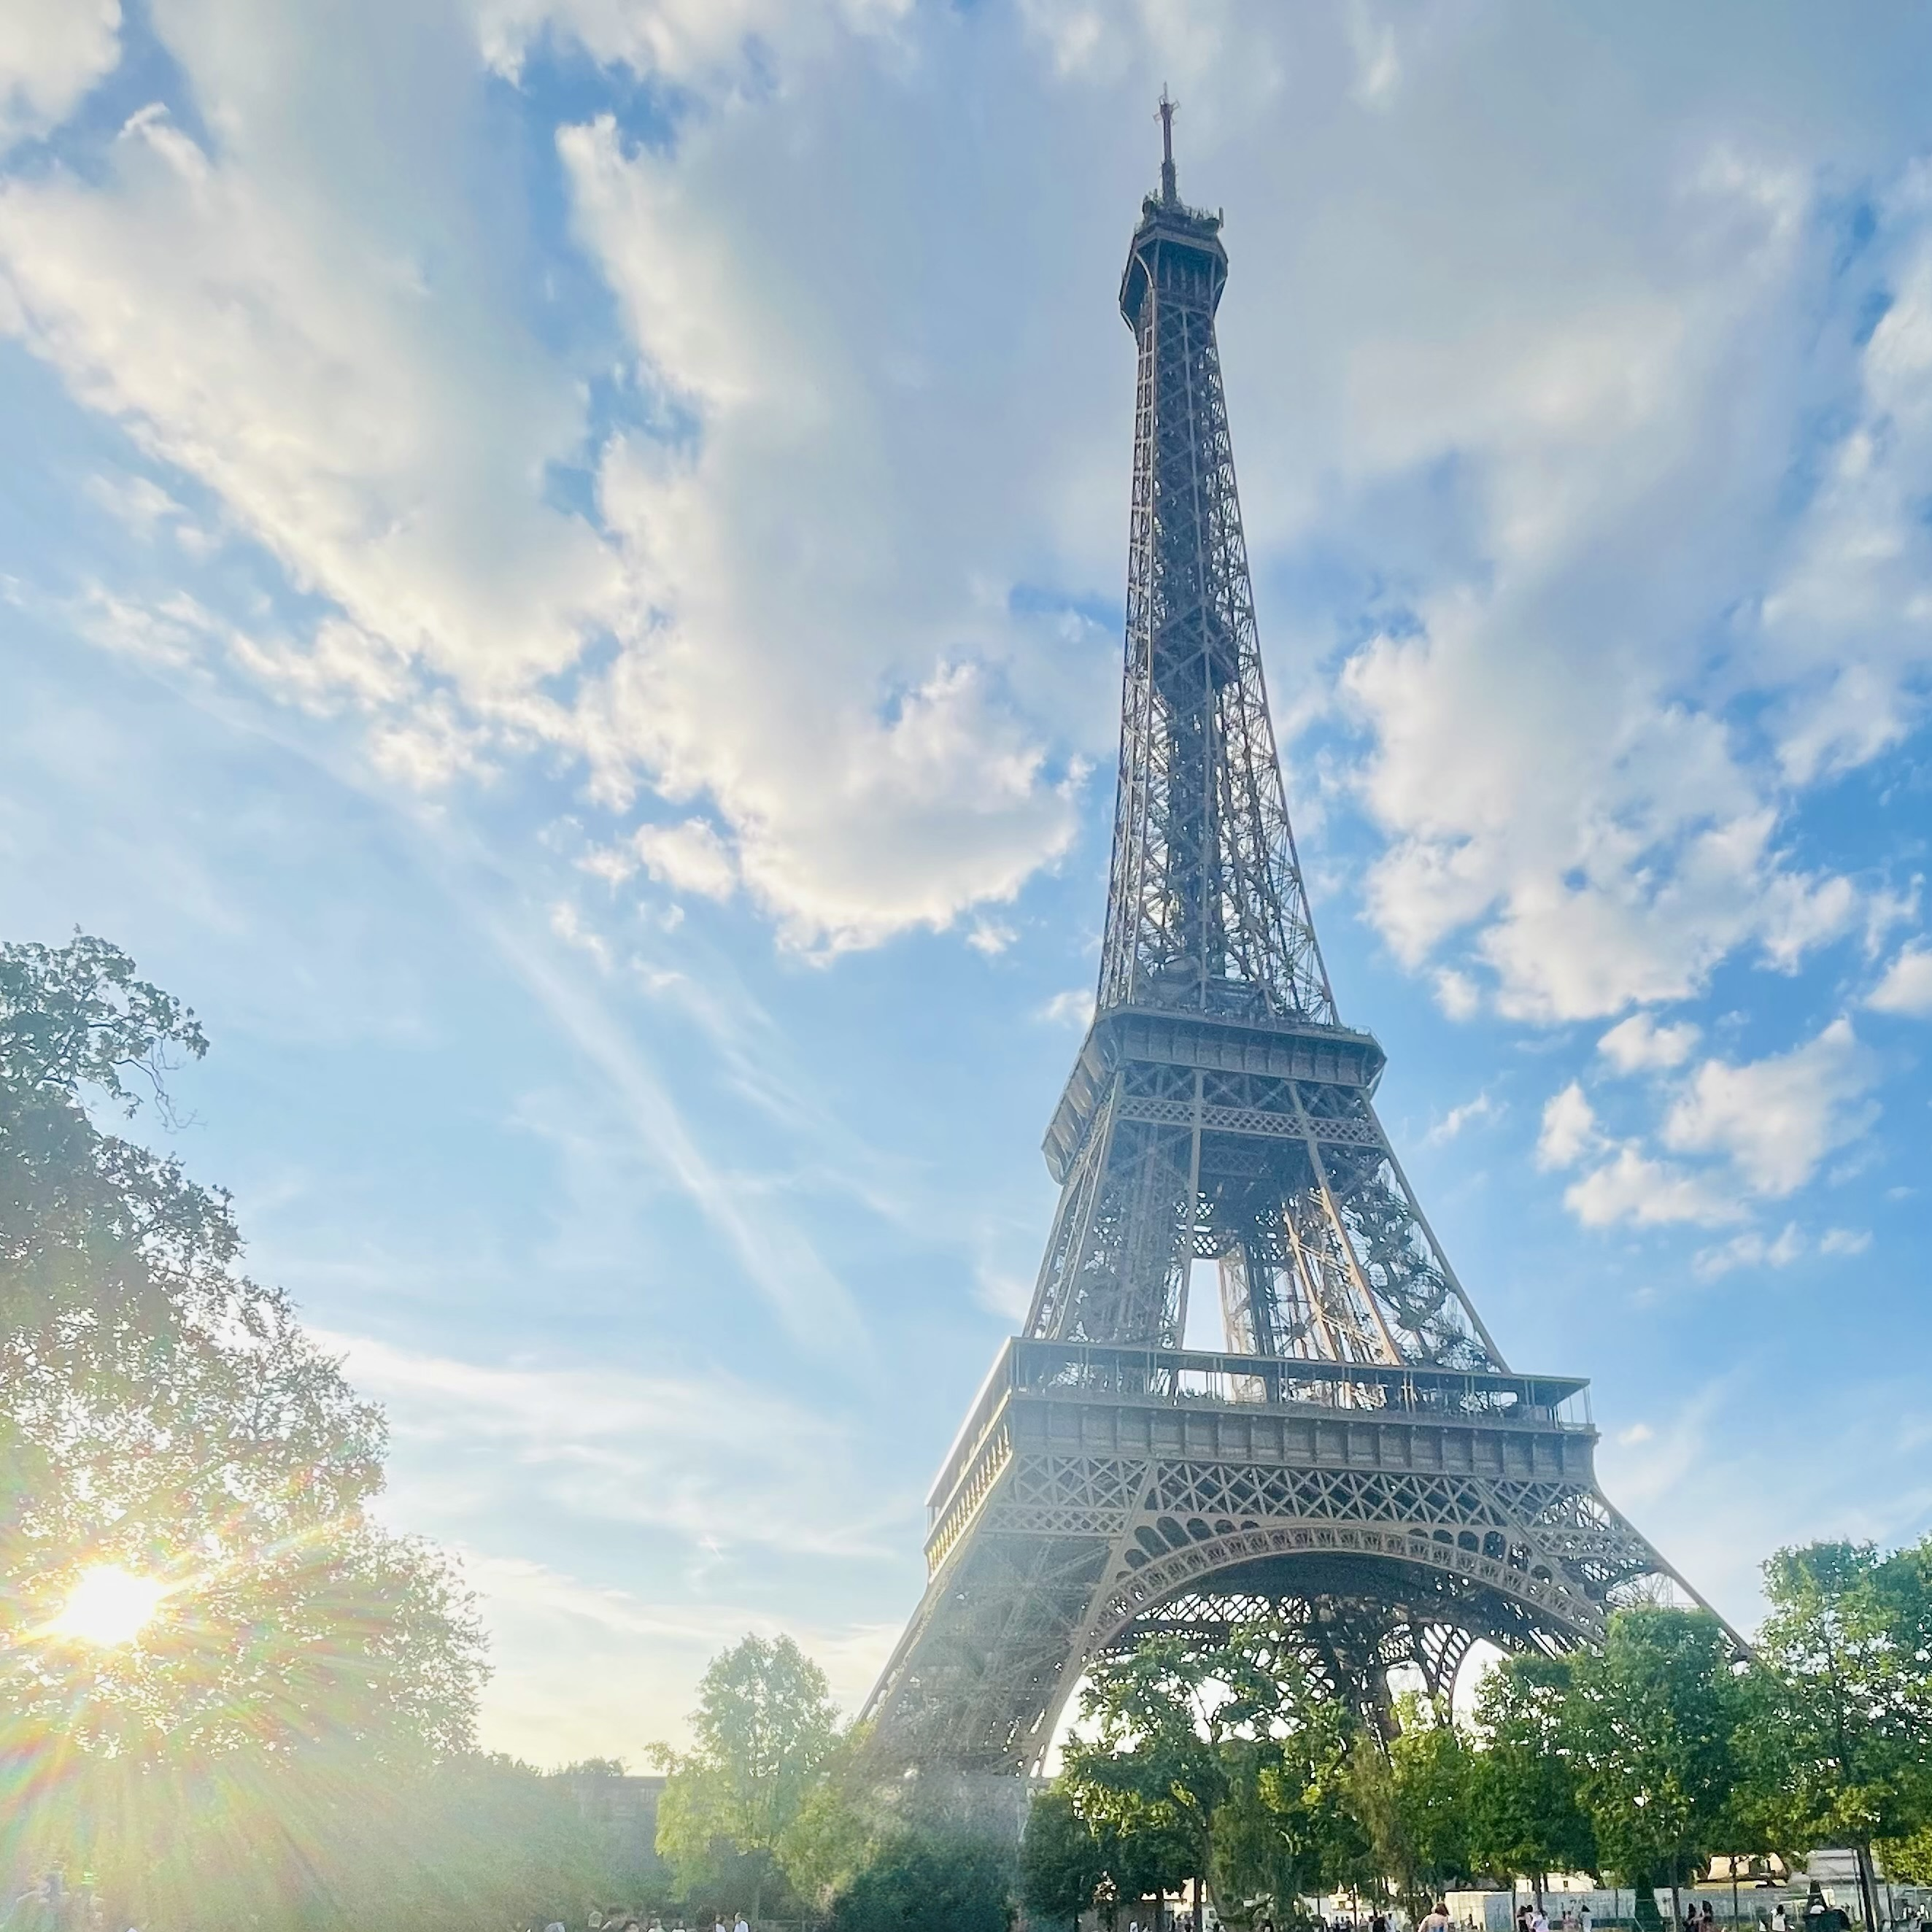

In [39]:
# Display the image
DisplayImage(image_path, width=400, height=400)

## Run Inference on the Full-Precision Model

* Define the question you want to ask about the image.
    * You can change the text in the string to ask your own custom question.

In [40]:
question = "Describe the scene in the image." ### <-- Replace with your question here

* Now, you will run the VQA task using the full-precision baseline model.
* Call the `perform_vqa` helper function, which handles the entire inference process and returns both the generated answer and the inference time it took.

In [41]:
baseline_answer, blip_model_inf_time = helper_utils.perform_vqa(blip_vqa_model, blip_vqa_processor, image_path, question)

In [42]:
# --- Print Results ---
print(f"Baseline Model Size: {blip_baseline_model_size:.2f} MB")
print(f"Baseline Inference Time: {blip_model_inf_time:.4f} s")
print("-" * 50)
print(f"Question: {question}")
print(f"Baseline Model Answer: {baseline_answer}")

Baseline Model Size: 1467.72 MB
Baseline Inference Time: 1.0902 s
--------------------------------------------------
Question: Describe the scene in the image.
Baseline Model Answer: eiffel tower


## Run Inference on Dynamically Quantized Model

* First, apply dynamic quantization on the BLIP VQA model.
    * `blip_vqa_model`: The variable holding the baseline model that you want to quantize.
        * **Note** that this operation only targets the model. The "processor" is simply a data-preparation helper; it doesn't contain the large, weighted neural network layers suitable for this optimization, so there's no need to consider it for quantization.
    * `{torch.nn.Linear}`: Only the `Linear` layers will be quantized. For Transformer-based models like BLIP, these layers contain the vast majority of the model's parameters and computational work, making them the most effective target for optimization.
    * `dtype=torch.qint8`: This sets the target data type for the quantized weights to 8-bit signed integers.
* After quantization, calculate the new model's size.

In [43]:
try:
    # Apply dynamic quantization to the Linear layers of the BLIP model
    quantized_blip_vqa_model = torch.quantization.quantize_dynamic(
        blip_vqa_model, 
        {torch.nn.Linear}, 
        dtype=torch.qint8
    )
    
    print("Dynamic quantization applied successfully to the BLIP model.")

except Exception as e:
    print(f"Failed to apply dynamic quantization. Error: {e}")


# Get the quantized model's size.
quantized_blip_model_size = helper_utils.get_model_size(quantized_blip_vqa_model)

Dynamic quantization applied successfully to the BLIP model.


* Now, you will run the VQA task using the quantized model.

In [44]:
quantized_answer, quantized_inf_time = helper_utils.perform_vqa(quantized_blip_vqa_model, blip_vqa_processor, image_path, question)

In [45]:
# --- Print Results ---
print(f"Quantized Model Size: {quantized_blip_model_size:.2f} MB")
print(f"Quantized Inference Time: {quantized_inf_time:.4f} s")
print("-" * 50)
print(f"Question: {question}")
print(f"Quantized Model Answer: {quantized_answer}")

Quantized Model Size: 508.19 MB
Quantized Inference Time: 0.7129 s
--------------------------------------------------
Question: Describe the scene in the image.
Quantized Model Answer: eiffel tower


## Compare Performance

In [46]:
helper_utils.blip_comparison_table(
    question=question,
    baseline_answer=baseline_answer,
    quantized_answer=quantized_answer,
    baseline_size=blip_baseline_model_size,
    quantized_size=quantized_blip_model_size,
    baseline_time_s=blip_model_inf_time,
    quantized_time_s=quantized_inf_time
)

,Model Size (MB),Inference Time (s),Answer
Baseline Model,1467.72,1.0902,eiffel tower
Quantized Model (Dynamic),508.19,0.7129,eiffel tower
Change,959.53 (65.4% reduction),0.3773 (34.6% reduction),---


Fantastic results! This is the moment where theory comes to life, showing the real-world power of quantization. Take a moment to look at what you've just accomplished, it's impressive!

First, look at the **Model Size**. You should see a massive reduction, likely around 65%, shrinking the model to a fraction of its original size! This is a huge victory. In the real world, this means faster download times, lower storage costs, and the ability to deploy powerful models on memory-constrained devices like mobile phones.

Now, take a look at the **Answers** from both models. What did they generate for your image? Are they the same? Do you agree with their description? It's incredible to see how even after compressing the model so significantly, the quantized version can produce an answer that is identical or makes just as much sense as the original. This is the goal of optimization: to gain efficiency while keeping the model intelligent and effective.

Finally, look at your **Inference Time**. Depending on your specific hardware and the current run, you might see a speed-up, a slow-down, or very little change. While theoretically, 8-bit integer math should be faster, the actual result depends on several factors:

* **Quantization Overhead**: Dynamic quantization has a small, fixed cost because it converts data types on-the-fly. For a single inference run, this overhead can sometimes outweigh the speed-up from the faster calculations.
* **Hardware and Environment**: Performance gains are highly dependent on the specific CPU architecture. The full benefits are often most visible in highly optimized, production-level environments.
* **Batch Size**: Optimization benefits are typically more pronounced when processing large batches of data at once. Since you are only inferring on a single image, the full potential may not be realized.

## Conclusion

In this notebook, you have performed a comprehensive, end-to-end exploration of model quantization. Starting with a floating-point baseline model, you have successfully applied three powerful PyTorch techniques and observed their impact on model size, inference speed, and accuracy.

You began with **Dynamic Quantization**, seeing how easily you can achieve a significant reduction in model size, a method that works particularly well for models like RNNs and transformers. You then moved to **Static Quantization**, a more nuanced post-training technique that requires a calibration step to also quantize activations, leading to even greater speed and memory savings, especially for CNNs. Finally, you dove deep into **Quantization-Aware Training (QAT)**. By modifying the model architecture for layer fusion and fine-tuning it to be "aware" of quantization noise, you produced a highly compressed model that preserved nearly all of its original accuracy. To ground these concepts, you also applied dynamic quantization to a large, pre-trained VQA model, observing firsthand the significant size reduction and its impact on output quality.

The skills you have developed here are essential for moving models from research to production. You are now equipped to analyze the trade-offs between implementation effort, model size, inference speed, and accuracy, allowing you to select the most appropriate quantization strategy for deploying efficient, high-performance models in a variety of real-world scenarios.